## Packages

In [5]:
!pip install pyro-ppl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 15.4 MB/s eta 0:00:00


In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
import random
import math
import torch
import os
import arviz as az

import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS, HMC

from sklearn.model_selection import train_test_split

## Setup

In [7]:
def g(x):
    return -torch.sin(6 * math.pi * x)**2 - 6*(x**2) - 5 * (x**4) + 3/2

In [8]:
def generate_dataset(random_state):
    l = 30
    xis = torch.tensor(np.linspace(0,1,l))
    yis = g(xis) + np.random.normal(0, 0.01, len(xis))
    xis_train, xis_test, yis_train, yis_test = train_test_split(xis,  yis, test_size=0.33, random_state = random_state)
    return xis_train, xis_test, yis_train, yis_test

xis_train, xis_test, yis_train, yis_test = generate_dataset(random_state = 0)
order = np.argsort(xis_train)
xis_train = xis_train[order]
yis_train = yis_train[order]
test_order = np.argsort(xis_test)
xis_test = xis_test[test_order]
yis_test = yis_test[test_order]

In [9]:
print(xis_train)
print(g(xis_train))
print(yis_train)

tensor([0.0000, 0.0345, 0.1034, 0.1379, 0.1724, 0.2069, 0.2414, 0.2759, 0.3103,
        0.4138, 0.4828, 0.5172, 0.5517, 0.6207, 0.6552, 0.6897, 0.7241, 0.7931,
        0.8621, 1.0000], dtype=torch.float64)
tensor([ 1.5000,  1.1266,  0.5722,  1.1182,  1.3055,  0.7611,  0.1596,  0.2339,
         0.6994, -0.6710, -0.2719, -0.5651, -1.4748, -2.1345, -2.0430, -2.6611,
        -3.8017, -4.7253, -5.9862, -9.5000], dtype=torch.float64)
tensor([ 1.4945,  1.1123,  0.5814,  1.1202,  1.3165,  0.7746,  0.1674,  0.2315,
         0.6815, -0.6821, -0.2734, -0.5884, -1.4949, -2.1291, -2.0533, -2.6756,
        -3.7956, -4.7206, -5.9796, -9.4876], dtype=torch.float64)


<Axes: xlabel='None', ylabel='None'>

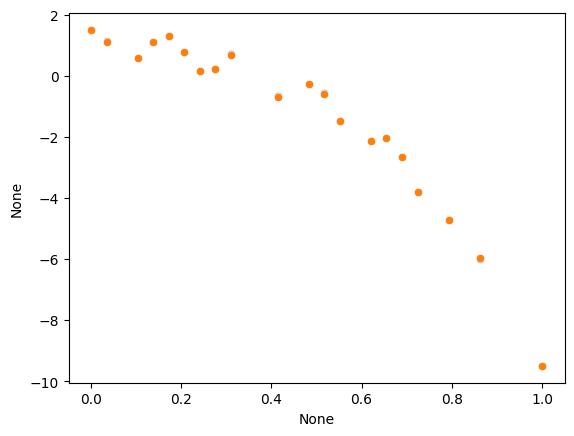

In [10]:
sns.scatterplot(x = xis_train, y = g(xis_train))
sns.scatterplot(x = xis_train, y = yis_train)



## Model

In [30]:
pyro.clear_param_store()
###Priors over kernel parameters
variance_prior = dist.HalfNormal(torch.tensor(10.0))  # Prior for variance #Normal(1, 1) works fine but sometimes unstable
lengthscale_prior = dist.HalfNormal(torch.tensor(3.0))  # Prior for lengthscale #Normal (1,1) also works fine
period_prior = dist.HalfNormal(torch.tensor(0.2))
#period_prior = dist.Normal(torch.tensor(0.2), torch.tensor(0.1))  # Prior for period
#noise could also be sampled from a prior?
noise_prior = dist.HalfNormal(torch.tensor(0.2))  # Prior for noise



In [31]:
pyro.clear_param_store()
def get_gpr(x_train, y_train, variance_prior, lengthscale_prior, period_prior, noise_prior):
    ###Sample from priors
    variance = pyro.sample("variance", variance_prior)
    #TEST:
    variance2 = pyro.sample("variance2", variance_prior)
    lengthscale = pyro.sample("lengthscale", lengthscale_prior)
    #TEST:
    lengthscale2 = pyro.sample("lengthscale2", lengthscale_prior)
    period = pyro.sample("period", period_prior)
    noise = pyro.sample("noise", noise_prior)

    period_kernel = gp.kernels.Periodic(
        input_dim = 1, variance = variance, lengthscale=lengthscale, period=period
    )

    rbf_kernel = gp.kernels.RBF(#TEST:
        input_dim = 1, variance = variance2, lengthscale=lengthscale2
    )

    combined_kernel = gp.kernels.Product(
        period_kernel, rbf_kernel
    )

    kernel = combined_kernel

    gpr = gp.models.GPRegression(x_train, y_train, kernel, noise=noise)

    return gpr

In [32]:
gpr = get_gpr(xis_train, yis_train, variance_prior, lengthscale_prior, period_prior, noise_prior)

In [33]:
def plot(
    plot_observed_data=False,
    plot_predictions=False,
    n_prior_samples=0,
    model=None,
    kernel=None,
    n_test=500,
    ax=None,
):

    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 6))
    if plot_observed_data:
        ax.plot(xis_train.numpy(), yis_train.numpy(), "x", label = 'train data', c = 'blue')
        ax.plot(xis_test.numpy(), yis_test.numpy(), "x", label = 'test data', c = 'black')
    if plot_predictions:
        # compute predictive mean and variance
        with torch.no_grad():
            if type(model) == gp.models.VariationalSparseGP:
                mean, cov = model(xis_train, full_cov=True)
            else:
                mean, cov = model(xis_train, full_cov=True, noiseless=False)
        sd = cov.diag().sqrt()  # standard deviation at each input point x
        ax.plot(xis_train.numpy(), mean.numpy(), "r", lw=2)  # plot the mean
        ax.fill_between(
            xis_train.numpy(),  # plot the two-sigma uncertainty about the mean
            (mean - 2.0 * sd).numpy(),
            (mean + 2.0 * sd).numpy(),
            color="C0",
            alpha=0.3,
        )
        ax.legend()

    if n_prior_samples > 0:  # plot samples from the GP prior
        xs_test = torch.linspace(0, 1, n_test)
        noise = (
            model.noise
            if type(model) != gp.models.VariationalSparseGP
            else model.likelihood.variance
        )
        cov = kernel.forward(xs_test) + noise.expand(n_test).diag()
        samples = dist.MultivariateNormal(
            torch.zeros(n_test), covariance_matrix=cov
        ).sample(sample_shape=(n_prior_samples,))
        ax.plot(xs_test.numpy(), samples.numpy().T, lw=2, alpha=0.4)

    ax.set_xlim(0, 1)


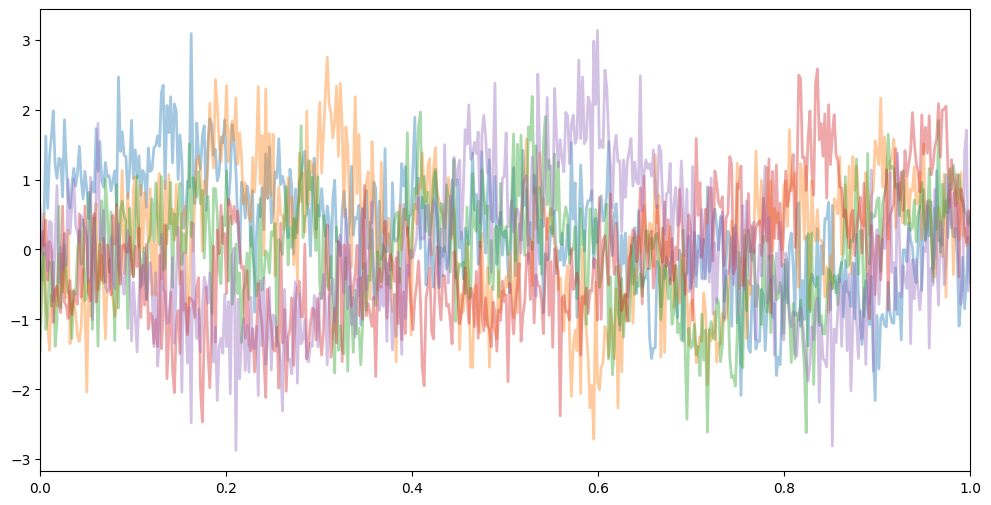

In [34]:
plot(model=gpr, kernel=gpr.kernel, n_prior_samples=5)
#_ = plt.ylim((-8, 8))

## MAP estimate

In [35]:
pyro.clear_param_store()

optimizer = torch.optim.Adam(gpr.parameters(), lr=0.002)
loss_fn = pyro.infer.Trace_ELBO().differentiable_loss
losses = []
num_steps = 2000
for i in range(num_steps):
    optimizer.zero_grad()
    loss = loss_fn(gpr.model, gpr.guide)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())



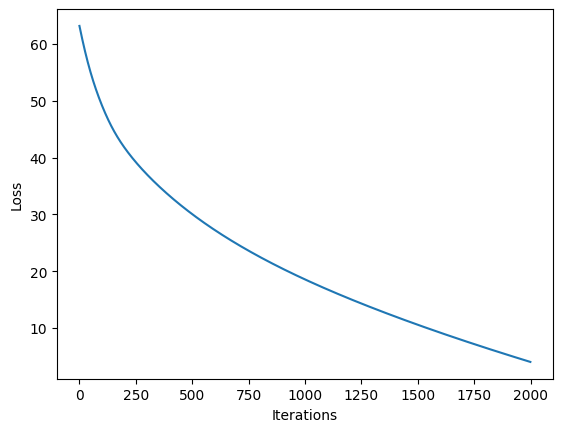

In [36]:
def plot_loss(loss):
    plt.plot(loss)
    plt.xlabel("Iterations")
    _ = plt.ylabel("Loss")  # supress output text

plot_loss(losses)

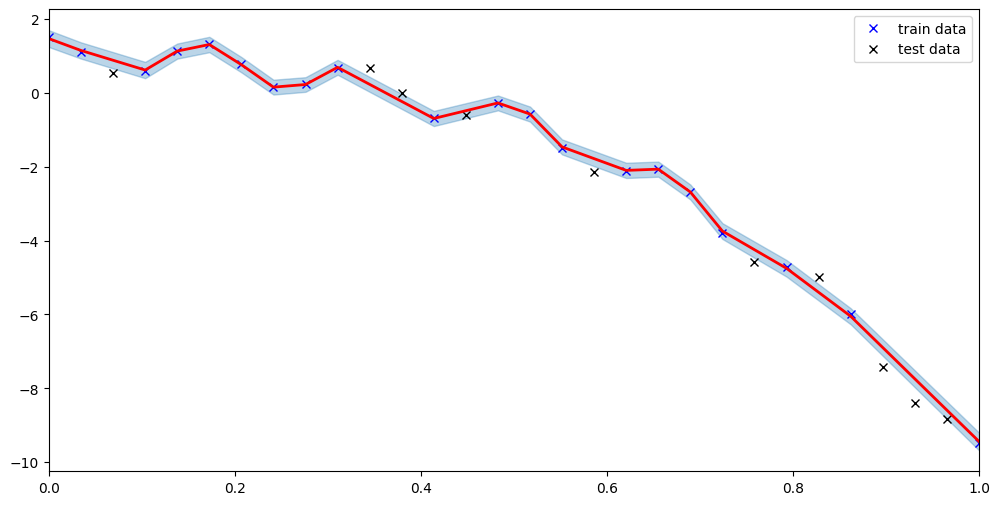

In [37]:
plot(model=gpr, plot_observed_data=True, plot_predictions=True)

In [39]:
def log_likelihood(gpr, x_test, y_test):
    with torch.no_grad():
        predictive_mean, predictive_cov = gpr(x_test, full_cov=True, noiseless=False)

        predictive_distribution = dist.MultivariateNormal(predictive_mean, predictive_cov)

        log_likelihood = predictive_distribution.log_prob(y_test)

        return log_likelihood.item()

log_likelihood(gpr, xis_test, yis_test)

10.780737854929486

## NUTS sampling

In [20]:
pyro.clear_param_store()
def model(x_train, y_train):
    ###Sample from priors
    variance = pyro.sample("variance", variance_prior)
    #TEST:
    variance2 = pyro.sample("variance2", variance_prior)
    lengthscale = pyro.sample("lengthscale", lengthscale_prior)
    #TEST:
    lengthscale2 = pyro.sample("lengthscale2", lengthscale_prior)
    period = pyro.sample("period", period_prior)
    noise = pyro.sample("noise", noise_prior)

    period_kernel = gp.kernels.Periodic(
        input_dim = 1, variance = variance, lengthscale=lengthscale, period=period
    )

    rbf_kernel = gp.kernels.RBF(#TEST:
        input_dim = 1, variance = variance2, lengthscale=lengthscale2
    )

    combined_kernel = gp.kernels.Product(
        period_kernel, rbf_kernel
    )

    kernel = combined_kernel

    gpr = gp.models.GPRegression(x_train, y_train, kernel, noise=noise)

    return gpr.model

In [21]:
nuts = NUTS(model)
mcmc = MCMC(nuts, num_samples=500, warmup_steps=250, num_chains = 4)
mcmc.run(xis_train, yis_train)
samples = mcmc.get_samples()

/usr/local/lib/python3.10/dist-packages/pyro/infer/mcmc/api.py:499: UserWarning: num_chains=4 is more than available_cpu=1. Chains will be drawn sequentially.
  warnings.warn(
Sample [3]: 100%|██████████| 750/750 [00:41, 18.20it/s, step size=3.14e-01, acc. prob=0.933]


               mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
lengthscale   2.335  1.768   0.006    5.501      0.047    0.033    1054.0   
lengthscale2  2.332  1.824   0.007    5.700      0.046    0.033     978.0   
noise         0.157  0.120   0.000    0.383      0.004    0.003     720.0   
period        0.156  0.119   0.001    0.372      0.003    0.002    1021.0   
variance      8.175  6.095   0.033   19.573      0.164    0.116     961.0   
variance2     7.831  5.819   0.024   18.261      0.168    0.119     797.0   

              ess_tail  r_hat  
lengthscale      759.0   1.00  
lengthscale2     697.0   1.00  
noise            579.0   1.01  
period           685.0   1.00  
variance         564.0   1.00  
variance2        482.0   1.00  


array([<Axes: title={'center': '94.0% HDI'}>,
       <Axes: title={'center': 'ess'}>], dtype=object)

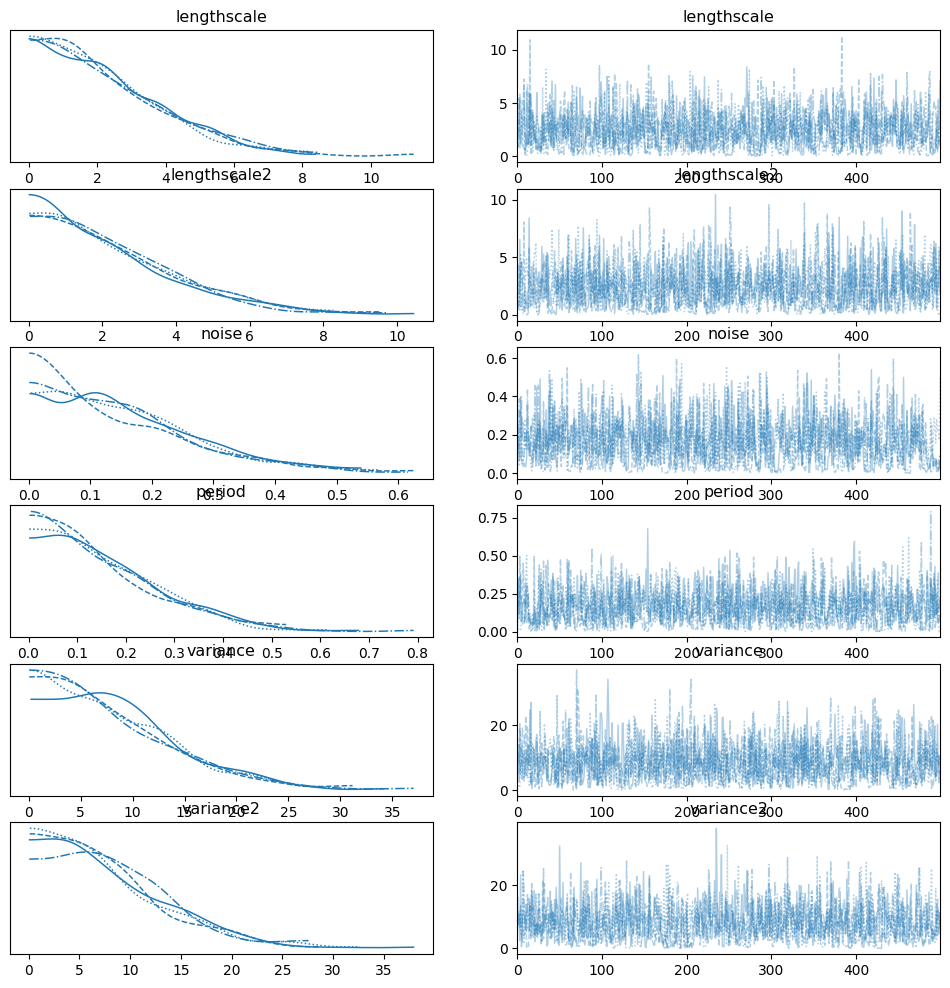

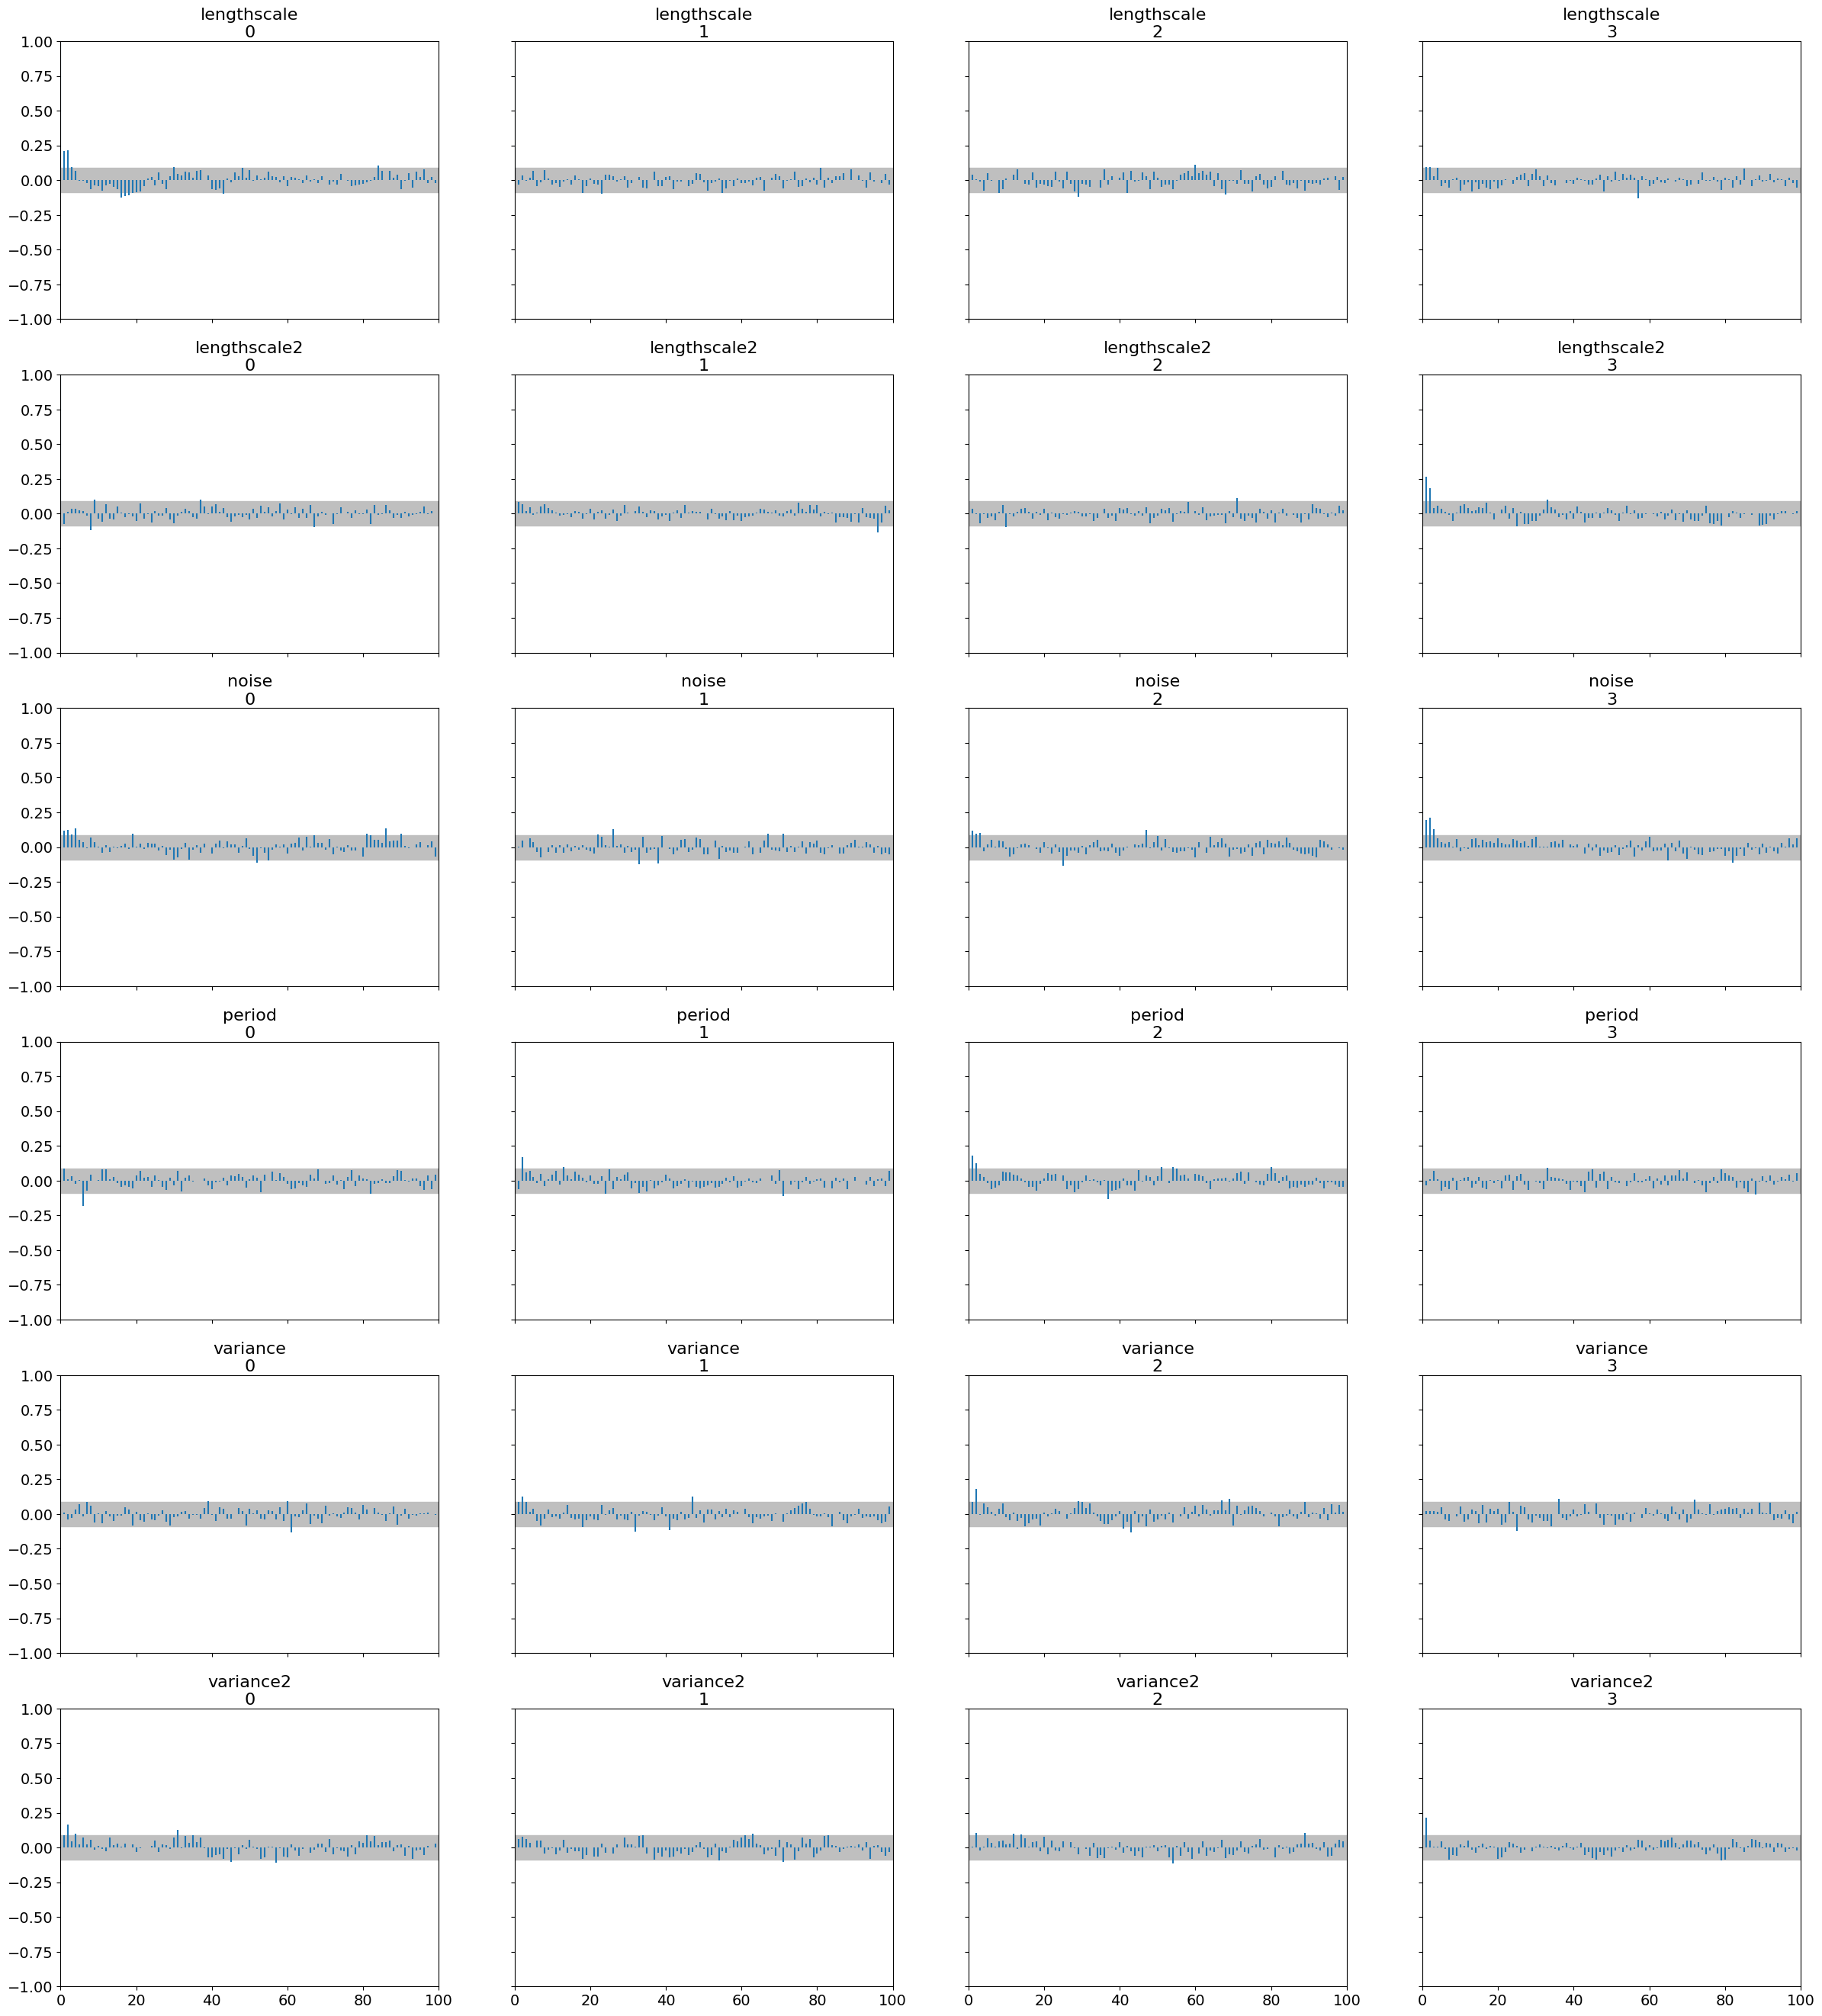

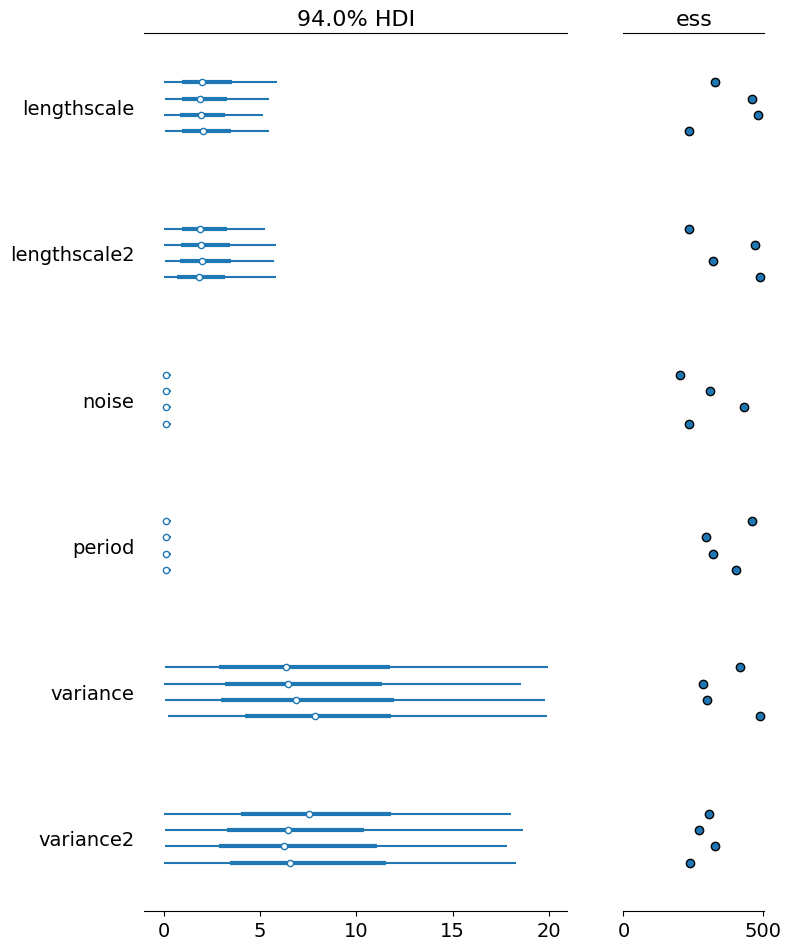

In [22]:
###Arviz diagnostics

posterior_data = az.from_pyro(mcmc)

print(az.summary(posterior_data))
az.plot_trace(posterior_data)
az.plot_autocorr(posterior_data)
az.plot_forest(posterior_data, ess = True)

In [27]:
sampled_variances = samples["variance"].detach().numpy()
sampled_variances2 = samples["variance2"].detach().numpy()
sampled_lengthscales = samples["lengthscale"].detach().numpy()
sampled_lengthscales2 = samples["lengthscale2"].detach().numpy()
sampled_periods = samples["period"].detach().numpy()
sampled_noises = samples["noise"].detach().numpy()

#500 samples
num_samples_to_use = 500
selected_indices = np.random.choice(len(sampled_variances), num_samples_to_use, replace=False)

selected_variances = sampled_variances[selected_indices]
selected_variances2 = sampled_variances2[selected_indices]
selected_lengthscales = sampled_lengthscales[selected_indices]
selected_lengthscales2 = sampled_lengthscales2[selected_indices]
selected_periods = sampled_periods[selected_indices]
selected_noises = sampled_noises[selected_indices]

#Compute the approximate posterior log-likelihood
log_likelihoods = []

for var, var2, length, length2, period, noise in zip(selected_variances, selected_variances2,
                                        selected_lengthscales, selected_lengthscales2,
                                                     selected_periods, selected_noises):

    period_kernel = gp.kernels.Periodic(
        input_dim = 1, variance = torch.tensor(var),
        lengthscale=torch.tensor(length), period=torch.tensor(period)
    )

    rbf_kernel = gp.kernels.RBF(
        input_dim = 1, variance = torch.tensor(var2),
                        lengthscale=torch.tensor(length2)
    )

    combined_kernel = gp.kernels.Product(
        period_kernel, rbf_kernel
    )

    kernel = combined_kernel

    #Compute predictive distribution
    with torch.no_grad():
        predictive_mean, predictive_cov = gpr(xis_test, full_cov=True, noiseless=False)

    predictive_distribution = dist.MultivariateNormal(predictive_mean, predictive_cov)

    #log-likelihood of the test outputs
    log_likelihood = predictive_distribution.log_prob(yis_test)
    log_likelihoods.append(log_likelihood.item())

#Approximate posterior log-likelihood
approximate_posterior_log_likelihood = sum(log_likelihoods) / len(log_likelihoods)

print(f"Approximate Posterior Log-Likelihood on Test Set: {approximate_posterior_log_likelihood}")

Approximate Posterior Log-Likelihood on Test Set: -7.076032360165301


### Testing for 20 different datasets (to be finished)

In [ ]:
res_df = {}
map_likelihoods = []
for i in range(20):
    x_train, x_test, y_train, y_test = generate_dataset(random_state = i)
    pyro.clear_param_store()

    gpr = get_gpr(x_train, y_train, variance_prior, lengthscale_prior, period_prior, noise_prior)

    #MAP
    optimizer = torch.optim.Adam(gpr.parameters(), lr=0.002)
    loss_fn = pyro.infer.Trace_ELBO().differentiable_loss
    losses = []
    num_steps = 2000
    for i in range(num_steps):
        optimizer.zero_grad()
        loss = loss_fn(gpr.model, gpr.guide)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    map_likelihood = log_likelihood(gpr, xis_test, yis_test)
    print(map_likelihood)
    map_likelihoods.append(map_likelihood)

    #NUTS
    #nuts = NUTS(model)
    #mcmc = MCMC(nuts, num_samples=500, warmup_steps=100, num_chains = 4)
    #mcmc.run(x_train, y_train)
    #samples = mcmc.get_samples()